# Reinforcement Learning with Replacing Eligibility Traces

Final project for **Stochastic Methods in Mathematical Modeling**

Student: Akhtyamov Timur

In [4]:
#!pip install gym

     |████████████████████████████████| 1.6 MB 579 kB/s eta 0:00:01
  Using cached pyglet-1.5.0-py2.py3-none-any.whl (1.0 MB)
  Created wheel for gym: filename=gym-0.17.2-py3-none-any.whl size=1650891 sha256=5a5e40307d77bf3aa39afb7f066c23ef2a406e070e8793dfb6945381e4bcc947
  Stored in directory: /home/ubuntu/.cache/pip/wheels/18/e1/58/89a2aa24e6c2cc800204fc02010612afdf200926c4d6bfe315
Successfully built gym


In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import gym

from IPython import display

np.random.seed(42)

## Experiment 1: Random-Walk

In [121]:
N_STATES = 21
START_STATE = 11
LEFT_ABSORBING_STATE = 1
RIGHT_ABSORBING_STATE = 21
LEFT_ABSORBING_REWARD = -1
RIGHT_ABSORBING_REWARD = 1

GT_STATE_VALUES = np.array([0] + [(2*n - 23) / 21 for n in range(2, 21)] + [0])

In [103]:
def sample_random_walks(n_samples):
    samples = []
    directions = [1, -1]
    for _ in range(n_samples):
        current_state = 11
        states = [current_state]
        rewards = []
        while current_state not in [LEFT_ABSORBING_STATE, RIGHT_ABSORBING_STATE]:
            current_state = current_state + np.random.choice(directions)
            states.append(current_state)
            if current_state == LEFT_ABSORBING_STATE:
                rewards.append(LEFT_ABSORBING_REWARD)
            elif current_state == RIGHT_ABSORBING_STATE:
                rewards.append(RIGHT_ABSORBING_REWARD)
            else:
                rewards.append(0)
        samples.append((np.array(states), np.array(rewards)))
    return samples

In [111]:
MODE_ACC = "acc"
MODE_REPLACE = "replace"

def td_lambda(random_walks, lmbda, alpha, mode, values_gt):
    value_estimates = np.zeros(N_STATES)
    traces = np.zeros(N_STATES)
    
    rmses = []
    
    for random_walk, rewards in random_walks:
        for t, state in enumerate(random_walk):
            # Common factor
            reward = rewards[t] if t != len(random_walk)-1 else 0
            current_value = value_estimates[state - 1]
            next_value = value_estimates[random_walk[t+1] - 1] if t != len(random_walk)-1 else 0
            factor = alpha * (reward + next_value - current_value)

            # Update traces
            traces = lmbda * traces
            if mode == MODE_ACC:
                traces[state - 1] += 1
            elif mode == MODE_REPLACE:
                traces[state - 1] = 1

            # Update value estimates
            value_estimates = value_estimates + factor * traces
        rmses.append(np.sqrt(np.mean((value_estimates - values_gt) ** 2)))
        
    return np.mean(rmses)

In [131]:
def random_walk_experiment(random_walk_samples, lmbdas, alphas, mode):
    lmbdas_rmses = []
    for lmbda in lmbdas:
        rmses = []
        for alpha in alphas:
            rmse = [td_lambda(random_walk_samples, lmbda=lmbda, alpha=alpha, mode=mode, values_gt=GT_STATE_VALUES) for _ in range(1000)]
            rmses.append(np.mean(rmse))
        lmbdas_rmses.append(rmses)
    return np.array(lmbdas_rmses)

In [114]:
random_walk_samples = sample_random_walks(10)

In [133]:
lmbdas = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.975, 0.99, 1.0]
alphas = np.linspace(0.0, 1.0, 100)

rmses_acc = random_walk_experiment(random_walk_samples, lmbdas, alphas, MODE_ACC)
rmses_replace = random_walk_experiment(random_walk_samples, lmbdas, alphas, MODE_REPLACE)

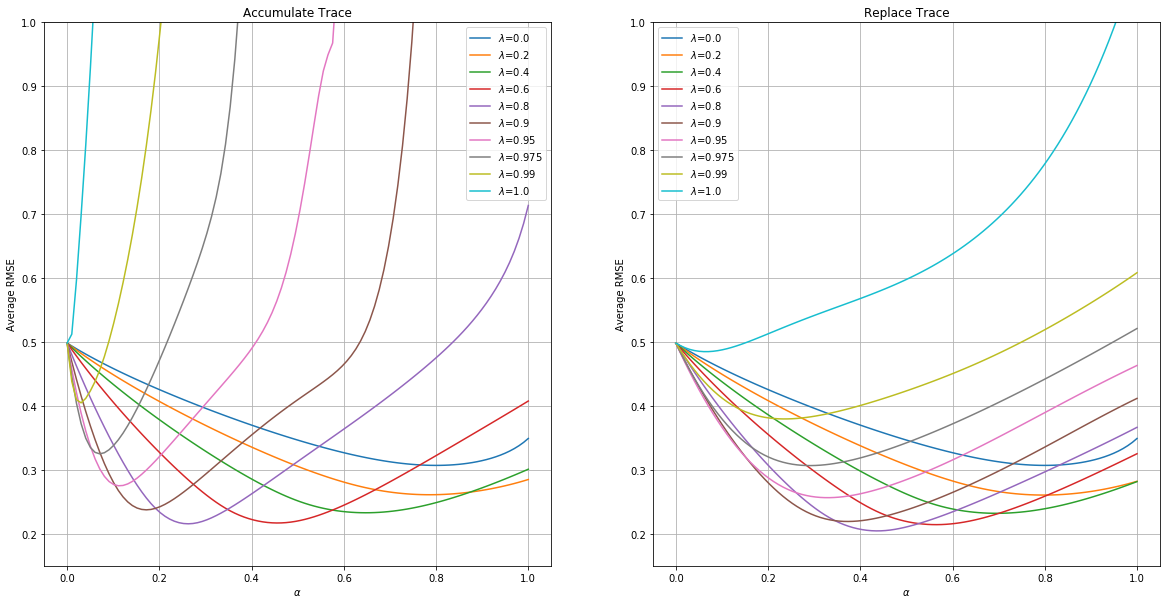

In [127]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax1.set_ylim(0.15, 1.0)
ax2.set_ylim(0.15, 1.0)

for i, lmbda in enumerate(lmbdas):
    ax1.plot(alphas, rmses_acc[i], label="$\\lambda$=" + str(lmbda))
    ax2.plot(alphas, rmses_replace[i], label="$\\lambda$=" + str(lmbda))
    
ax1.set_title("Accumulate Trace")
ax2.set_title("Replace Trace")
for ax in [ax1, ax2]:
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel("Average RMSE")
    ax.grid()
    ax.legend()
    
plt.show()

In [125]:
best_acc = np.min(rmses_acc, axis=1)
best_replace = np.min(rmses_replace, axis=1)

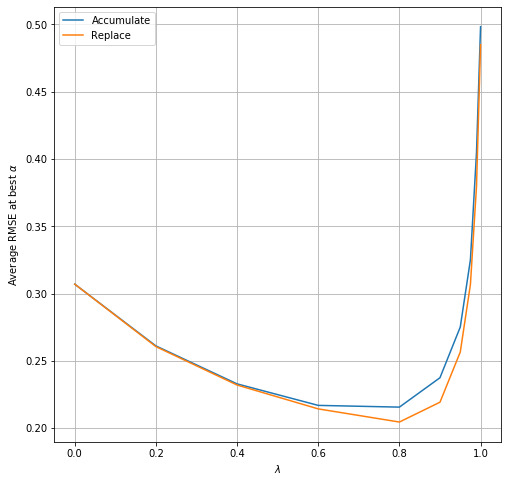

In [128]:
plt.figure(figsize=(8, 8))

plt.plot(lmbdas, best_acc, label="Accumulate")
plt.plot(lmbdas, best_replace, label="Replace")

plt.xlabel("$\\lambda$")
plt.ylabel("Average RMSE at best $\\alpha$")
plt.grid()
plt.legend()
plt.show()

## Experiment 2: Mountain Car

In [6]:
ACTION_PUSH_LEFT = 0
ACTION_NO_PUSH = 1
ACTION_PUSH_RIGHT = 2

MODE_ACC = "acc"
MODE_REPLACE = "replace"

In [7]:
class CMACNetwork:
    def __init__(self, state_space, action_space, n_tiles_side, n_tilings, initial_weights=-20.0):
        self.state_space_ = state_space
        self.action_dim_ = action_space.n
        self.n_tilings_ = n_tilings
        self.n_tiles_side_ = n_tiles_side
        self.tilings_ = np.ones((action_space.n, n_tilings, n_tiles_side + 1, n_tiles_side + 1)) * initial_weights
        self.tile_width_ = (state_space.high - state_space.low) / n_tiles_side
        self.offsets_ = [np.random.uniform() * self.tile_width_ for _ in range(n_tilings)]
        
    def encode(self, state):
        positions = []
        features = np.zeros((self.action_dim_,))
        
        for i in range(self.n_tilings_):
            limit_min = self.state_space_.low - self.offsets_[i]
            position = ((state - limit_min) // self.tile_width_).astype(np.int64)
            positions.append(np.concatenate([[i], position]))
            features = features + self.tilings_[:, i, position[0], position[1]]
        
        return features, np.array(positions)
    
    def shape(self):
        return self.tilings_.shape
    
    def reset(self, initial_weights=-20.0):
        self.tilings_ = np.ones((self.action_dim_, self.n_tilings_, self.n_tiles_side_ + 1, self.n_tiles_side_ + 1)) * initial_weights

In [8]:
def greedy_policy(features):
    return np.random.choice(np.where(features == np.max(features))[0])    


def sarsa(env, cmac, lmbda, alpha, mode, n_trials=20, start_positions=None):    
    n_steps_trials = []
    
    cmac.reset()
    traces = np.zeros(cmac.shape())
    
    for trial in range(n_trials):
        # Start of the trial
        state = env.reset()
        if start_positions is not None:
            env.state = np.array([start_positions[trial], 0.0])
        done = False
        n_steps = 0

        # Generate first action
        features, positions = cmac.encode(state)
        action = greedy_policy(features)

        while not done:
            n_steps += 1

            # Update traces
            traces = traces * lmbda
            if mode == MODE_ACC:
                for pos in positions:
                    traces[action, pos[0], pos[1], pos[2]] = traces[action, pos[0], pos[1], pos[2]] + 1.0
            elif mode == MODE_REPLACE:
                for i in range(traces.shape[0]):
                    for pos in positions:
                        if i == action:
                            traces[i, pos[0], pos[1], pos[2]] = 1.0
                        else:
                            traces[i, pos[0], pos[1], pos[2]] = 0.0

            # Apply action
            state, r, done, _ = env.step(action)

            # Generate new action
            features_next, positions_next = cmac.encode(state)
            action_next = greedy_policy(features_next)

            # Learning step
            if not done:
                factor = (alpha / 5.0) * (r + features_next[action_next] - features[action])
            else:
                factor = (alpha / 5.0) * (r - features[action])
            cmac.tilings_ = cmac.tilings_ + factor * traces
            
            if done:
                break

            # Loop action
            features = features_next
            positions = positions_next
            action = action_next
        
        n_steps_trials.append(n_steps)
        
    return np.mean(n_steps_trials)

In [27]:
N_TRIALS = 20
start_states = np.array([np.random.uniform(low=-0.6, high=-0.4) for _ in range(N_TRIALS)])

env = gym.make("MountainCar-v0")
env._max_episode_steps = 900

cmac = CMACNetwork(env.observation_space, env.action_space, 8, 5, initial_weights=-20)

In [96]:
def mountain_car_experiment(env, cmac, lmbdas, alphas, start_states, mode):
    n_steps_lmbdas = []
    for i, lmbda in enumerate(lmbdas):
        n_steps_lmbda = []
        for j, alpha in enumerate(alphas):
            n_steps_alpha = []
            for _ in range(30):
                n_steps = sarsa(env, cmac, lmbda=lmbda, alpha=alpha, mode=mode, n_trials=N_TRIALS, 
                                start_positions=start_states)
                n_steps_alpha.append(n_steps)
            n_steps_lmbda.append(np.array(n_steps_alpha).mean())
        n_steps_lmbdas.append(n_steps_lmbda)
    return n_steps_lmbdas

In [2]:
lmbdas_replace = np.array([0.0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0])
alphas_replace = np.linspace(0.0, 1.2, 6)

n_steps_replace = mountain_car_experiment(env, cmac, lmbdas_replace, alphas_replace, start_states, MODE_REPLACE)

In [3]:
lmbdas_acc = np.array([0.0, 0.3, 0.5, 0.6])
alphas_acc = np.linspace(0.0, 0.94, 5)

n_steps_acc = mountain_car_experiment(env, cmac, lmbdas_acc, alphas_acc, start_states, MODE_ACC)

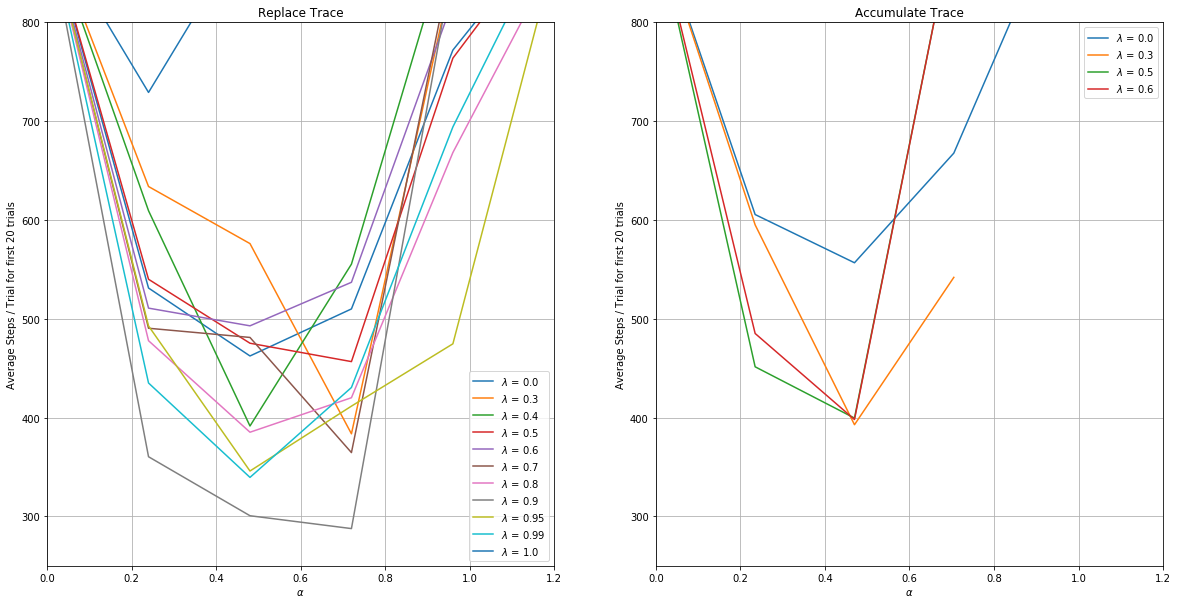

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax1.set_xlim(0.0, 1.2)
ax2.set_xlim(0.0, 1.2)
ax1.set_ylim(250, 800)
ax2.set_ylim(250, 800)

for i in range(len(lmbdas_replace)):
    ax1.plot(alphas_replace[:len(n_steps_replace[i])], n_steps_replace[i], label="$\\lambda$ = " + str(lmbdas_replace[i]))

for i in range(len(lmbdas_acc)):
    ax2.plot(alphas_acc[:len(n_steps_acc[i])], n_steps_acc[i], label="$\\lambda$ = " + str(lmbdas_acc[i]))


ax1.set_title("Replace Trace")
ax2.set_title("Accumulate Trace")
for ax in [ax1, ax2]:
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel("Average Steps / Trial for first 20 trials")
    ax.grid()
    ax.legend()
    
plt.show()

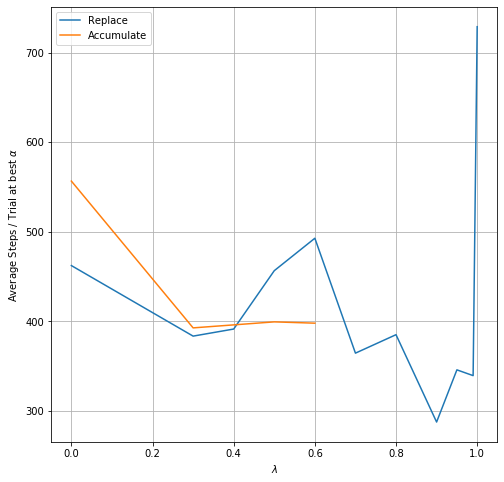

In [101]:
best_replace = [np.min(n_steps) for n_steps in n_steps_replace]
best_acc = [np.min(n_steps) for n_steps in n_steps_acc]

plt.figure(figsize=(8, 8))

plt.plot(lmbdas_replace, best_replace, label="Replace")
plt.plot(lmbdas_acc, best_acc, label="Accumulate")

plt.xlabel("$\\lambda$")
plt.ylabel("Average Steps / Trial at best $\\alpha$")
plt.grid()
plt.legend()
plt.show()